In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../../src/')

In [3]:
from pathlib import Path
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns

In [4]:
DATA_DIR = Path('../../data/platesmania_data/')
IMAGES_DIR = DATA_DIR / 'plate_images/full'
BBOX_DIR = DATA_DIR / 'bboxes'

In [5]:
df = pd.read_json(DATA_DIR / 'platesmania.json')
df.head()

full_img_file  \
0  2db1f8de74e52dd948244ddb526752c64cbf134c.jpg   
1  826307bccc0f7d9205a7ba3c52a63399c005a582.jpg   
2  d45deb7eb7e1af1d5adf01d1f9c1ecf8477e30d8.jpg   
3  ea76ccf486ec4d04b5f1d0622400c90affca88cd.jpg   
4  17984be6f202bf586704b63966cedb6033d82ab9.jpg   

                                 plate_img_file       text  
0  7f39adae9234cddf550dfc3f7a8956b6172891b1.jpg     SBE 8X  
1  f0b3ff1629d24086bc4166e1a1869ad891c74bf8.jpg   WE 086EN  
2  023e49296c2f5570d4cb073551a958e9d45d80b6.jpg   BI 5984Y  
3  e05e99e04e81ec95e876246a62b66de1373dfd8d.jpg   SNE 8108  
4  ba8a81053a00f5e3854601a05a6b03d9f9f1693a.jpg  WGM 40927

In [6]:
tests_df = pd.read_csv('./experiments_results_normal_x.csv', index_col=0)
tests_df.rename({
    'filename': 'full_img_file', 
     'x2': 'x_pred', 
     'y2': 'y_pred',
     'w2': 'w_pred',
     'h2': 'h_pred'
    }, 
    axis=1, inplace=True)
tests_df.tail()

full_img_file     x1     y1     w1     h1  \
107  365c27433f9329bb6700087955aebaec700892c8.jpg  224.0  656.0  207.0   69.0   
108  0652163679f4ae71e063eab9fb8702f8a1dcc60e.jpg  959.0  695.0  334.0  111.0   
109  47b43e1620d340f42cf09c27c9144ab2c08d47f3.jpg  517.0  680.0  229.0   76.0   
110  3dbc3ce39cdf356a88468dd4f646323c6871d4bb.jpg  300.0  729.0  272.0  109.0   
111  0abc5c9294f68a93b9fa17664a08d69ac67d81f8.jpg  331.0  653.0  250.0   83.0   

     x_pred  y_pred  w_pred  h_pred pred_text  cas_idx  
107   265.0   651.0   164.0    67.0  L?WASM75      0.0  
108  1056.0   727.0   206.0    67.0   EL237XV      0.0  
109   526.0   696.0   193.0    47.0    RP7675      0.0  
110   302.0   729.0   275.0   101.0  ZSW?P797      1.0  
111   390.0   673.0   161.0    51.0     RP846      0.0

In [7]:
def parse_yolo_format(bbox_line):
    return [float(pos) for pos in bbox_line[:-1].split(' ')[1:]]

bbox_line = '15 0.300000 0.840000 0.162857 0.083810\n'
parse_yolo_format(bbox_line)

[0.3, 0.84, 0.162857, 0.08381]

In [8]:
data = []

for bbox_file in BBOX_DIR.glob("*.txt"):
    with open(bbox_file, "r") as f:
        bbox_line = f.readline()
        bbox_data = parse_yolo_format(bbox_line)
        data.append([bbox_file.name[:-3] + 'jpg', *bbox_data])
        
bbox_df = pd.DataFrame(data, columns=['full_img_file', 'x_org', 'y_org', 'w_org', 'h_org'])
bbox_df.head()

full_img_file     x_org     y_org     w_org  \
0  1ade9225dd351326d3e9f360bfbc6727bd33fd0a.jpg  0.300000  0.840000  0.162857   
1  231102792489f910550824bae2a70e95b0d1278f.jpg  0.683958  0.659801  0.110136   
2  2cd1b816f76fb8d199b642eec0fb2401521f0424.jpg  0.285625  0.766667  0.130000   
3  28b7644cc1eb87b2363f211a841bce78b3874817.jpg  0.465972  0.532870  0.254167   
4  1257cec50c9e786911fae328ee1c2d8cc178ac2e.jpg  0.416250  0.713750  0.200000   

      h_org  
0  0.083810  
1  0.075284  
2  0.050000  
3  0.080556  
4  0.080833

In [9]:
merged_df = bbox_df.merge(df, on='full_img_file').merge(tests_df, on='full_img_file')
merged_df.drop('plate_img_file', inplace=True, axis=1)
merged_df.head()

full_img_file     x_org     y_org     w_org  \
0  1ade9225dd351326d3e9f360bfbc6727bd33fd0a.jpg  0.300000  0.840000  0.162857   
1  231102792489f910550824bae2a70e95b0d1278f.jpg  0.683958  0.659801  0.110136   
2  231102792489f910550824bae2a70e95b0d1278f.jpg  0.683958  0.659801  0.110136   
3  2cd1b816f76fb8d199b642eec0fb2401521f0424.jpg  0.285625  0.766667  0.130000   
4  28b7644cc1eb87b2363f211a841bce78b3874817.jpg  0.465972  0.532870  0.254167   

      h_org      text     x1     y1     w1     h1  x_pred  y_pred  w_pred  \
0  0.083810  WF 0480C  339.0  835.0  229.0   76.0   334.0   849.0   188.0   
1  0.075284  CSW 32J4  784.0  438.0  162.0   54.0   804.0   442.0   119.0   
2  0.075284  CSW 32J4   32.0  523.0  190.0   64.0    49.0   537.0   142.0   
3  0.050000  KR 7Y153  315.0  864.0  292.0   97.0   372.0   895.0   180.0   
4  0.080556  SRC 71SA  471.0  498.0  428.0  143.0   536.0   541.0   304.0   

   h_pred pred_text  cas_idx  
0    65.0   WF0480C      0.0  
1    42.0   CSW32J4      0.0  
2    41.0    PF850G      0.0  
3    46.0   KR7Y153      0.0  
4    69.0    SRC71A      0.0

In [10]:
merged_df.to_csv('merged-stats.csv')

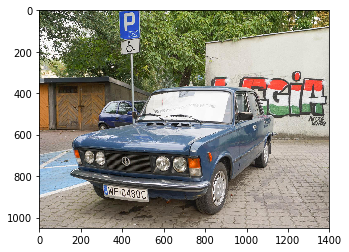

In [11]:
selected_index = 0
selected_img = merged_df.loc[selected_index]
img_path = IMAGES_DIR / selected_img.full_img_file

image = plt.imread(img_path)

plt.imshow(image)

In [12]:
def convert_yolo_format_to_matplot_rectangle_format(image, df):
    height, width, _ = image.shape
    
    bbox_width = df.w_org * width
    bbox_height = df.h_org * height
    
    bbox_x = df.x_org * width - bbox_width / 2
    bbox_y = df.y_org * height - bbox_height / 2
    
    return bbox_x, bbox_y, bbox_width, bbox_height

bbox = convert_yolo_format_to_matplot_rectangle_format(image, selected_img)

In [13]:
def add_bbox_to_ax(bbox, ax, color='r'):
    x, y, width, height = bbox
    
    rect = patches.Rectangle((x, y), 
                         width, height,
                         linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    return ax

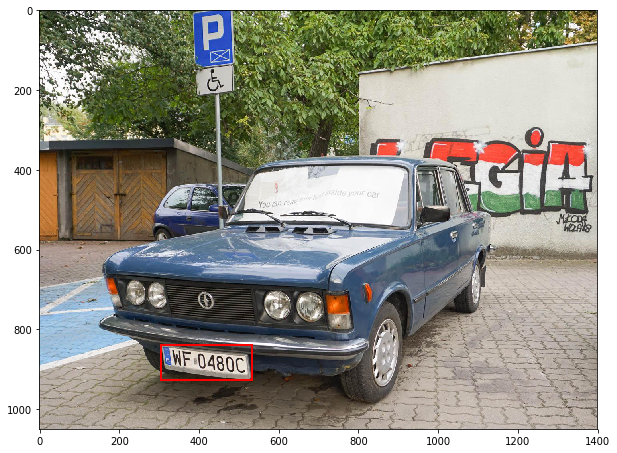

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
add_bbox_to_ax(bbox, ax)


In [15]:
def reset_coordinates(bbox):
    x, y, w, h = bbox
    return x, y, x + w, y + h

def bb_intersection_over_union(boxA, boxB):
    boxA = reset_coordinates(boxA)
    boxB = reset_coordinates(boxB)
    
    # source: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [16]:
bbox_x, bbox_y, bbox_width, bbox_height = bbox

bbox_a  = (bbox_x, bbox_y, bbox_width, bbox_height)
bbox_b  = (bbox_x, bbox_y, bbox_width - 50, bbox_height + 30)

bb_intersection_over_union(bbox_a, bbox_a)

1.0

0.6186561915205349

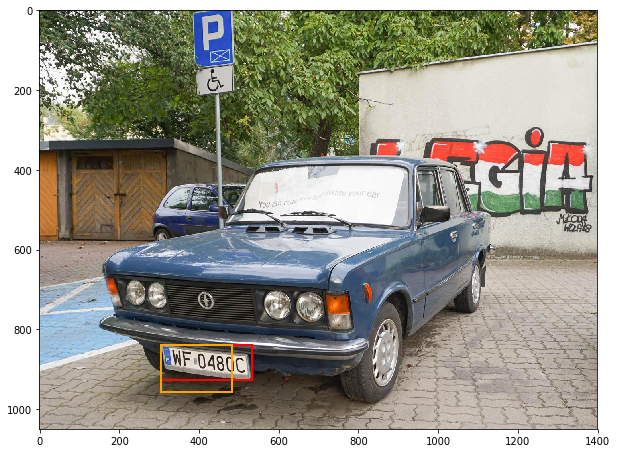

In [17]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

add_bbox_to_ax(bbox_a, ax)
add_bbox_to_ax(bbox_b, ax, color='orange')

bb_intersection_over_union(bbox_a, bbox_b)

In [18]:
def get_jacuqard_for_original_and_predicted_bbox(record, return_axes=False):
    image = plt.imread(IMAGES_DIR / record.full_img_file)

    bbox_org = convert_yolo_format_to_matplot_rectangle_format(image, record)
    bbox_pred = record[['x_pred', 'y_pred', 'w_pred', 'h_pred']].values
    
    iou = bb_intersection_over_union(bbox_org, bbox_pred)

    if return_axes:
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)

        ax = add_bbox_to_ax(bbox_org, ax)
        ax = add_bbox_to_ax(bbox_pred, ax, color='blue')
        
        ax.set_title(f'Jacuqard = {iou}')
        return ax
    return iou

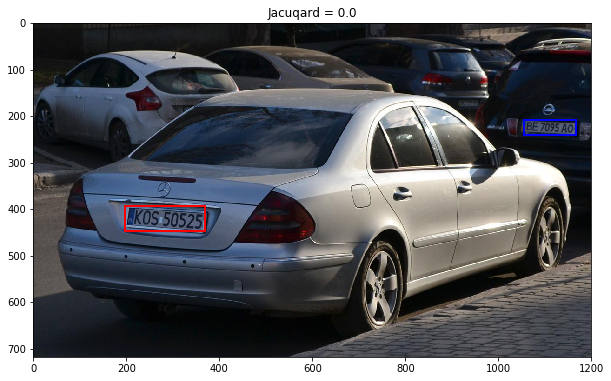

In [19]:
get_jacuqard_for_original_and_predicted_bbox(merged_df.loc[73], return_axes=True)


### Edit images with multiple plates

In [20]:
searched_img = '231102792489f910550824bae2a70e95b0d1278f.jpg'

display(merged_df[merged_df.full_img_file == searched_img])
index_to_edit = 2

merged_df.loc[index_to_edit, 'x_org'] = 0.094972
merged_df.loc[index_to_edit, 'y_org'] = 0.791193
merged_df.loc[index_to_edit, 'w_org'] = 0.122905
merged_df.loc[index_to_edit, 'h_org'] = 0.059659

merged_df.loc[index_to_edit, 'text'] = 'PF850G'

display(merged_df[merged_df.full_img_file == searched_img])


full_img_file     x_org     y_org     w_org  \
1  231102792489f910550824bae2a70e95b0d1278f.jpg  0.683958  0.659801  0.110136   
2  231102792489f910550824bae2a70e95b0d1278f.jpg  0.683958  0.659801  0.110136   

      h_org      text     x1     y1     w1    h1  x_pred  y_pred  w_pred  \
1  0.075284  CSW 32J4  784.0  438.0  162.0  54.0   804.0   442.0   119.0   
2  0.075284  CSW 32J4   32.0  523.0  190.0  64.0    49.0   537.0   142.0   

   h_pred pred_text  cas_idx  
1    42.0   CSW32J4      0.0  
2    41.0    PF850G      0.0

full_img_file     x_org     y_org     w_org  \
1  231102792489f910550824bae2a70e95b0d1278f.jpg  0.683958  0.659801  0.110136   
2  231102792489f910550824bae2a70e95b0d1278f.jpg  0.094972  0.791193  0.122905   

      h_org      text     x1     y1     w1    h1  x_pred  y_pred  w_pred  \
1  0.075284  CSW 32J4  784.0  438.0  162.0  54.0   804.0   442.0   119.0   
2  0.059659    PF850G   32.0  523.0  190.0  64.0    49.0   537.0   142.0   

   h_pred pred_text  cas_idx  
1    42.0   CSW32J4      0.0  
2    41.0    PF850G      0.0

In [21]:
searched_img = '091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg'

display(merged_df[merged_df.full_img_file == searched_img])
index_to_edit = 110

merged_df.loc[index_to_edit, 'x_org'] = 0.127778
merged_df.loc[index_to_edit, 'y_org'] = 0.205556
merged_df.loc[index_to_edit, 'w_org'] = 0.052778
merged_df.loc[index_to_edit, 'h_org'] = 0.018519

merged_df.loc[index_to_edit, 'text'] = 'W12897R'

display(merged_df[merged_df.full_img_file == searched_img])


full_img_file     x_org     y_org  \
110  091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg  0.513889  0.791667   
111  091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg  0.513889  0.791667   

        w_org    h_org       text     x1     y1     w1     h1  x_pred  y_pred  \
110  0.259722  0.07963  RLA 01373  130.0  202.0  109.0   36.0   144.0   209.0   
111  0.259722  0.07963  RLA 01373  557.0  783.0  417.0  139.0   591.0   824.0   

     w_pred  h_pred pred_text  cas_idx  
110    78.0    25.0   W12897R      0.0  
111   327.0    71.0  RLA01373      0.0

full_img_file     x_org     y_org  \
110  091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg  0.127778  0.205556   
111  091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg  0.513889  0.791667   

        w_org     h_org       text     x1     y1     w1     h1  x_pred  \
110  0.052778  0.018519    W12897R  130.0  202.0  109.0   36.0   144.0   
111  0.259722  0.079630  RLA 01373  557.0  783.0  417.0  139.0   591.0   

     y_pred  w_pred  h_pred pred_text  cas_idx  
110   209.0    78.0    25.0   W12897R      0.0  
111   824.0   327.0    71.0  RLA01373      0.0

In [22]:
searched_img = '34afacee7371c37c5508d15c5995a12b5d33d5c0.jpg'

display(merged_df[merged_df.full_img_file == searched_img])
index_to_edit = 44

merged_df.loc[index_to_edit, 'x_org'] = 0.945833
merged_df.loc[index_to_edit, 'y_org'] = 0.399537
merged_df.loc[index_to_edit, 'w_org'] = 0.076389
merged_df.loc[index_to_edit, 'h_org'] = 0.054630

merged_df.loc[index_to_edit, 'text'] = 'WPI32932'

display(merged_df[merged_df.full_img_file == searched_img])

full_img_file     x_org     y_org  \
44  34afacee7371c37c5508d15c5995a12b5d33d5c0.jpg  0.650694  0.729167   
45  34afacee7371c37c5508d15c5995a12b5d33d5c0.jpg  0.650694  0.729167   

       w_org     h_org      text      x1     y1     w1     h1  x_pred  y_pred  \
44  0.193056  0.115741  SC 67338  1299.0  410.0  114.0   45.0  1352.0   407.0   
45  0.193056  0.115741  SC 67338   298.0  540.0  832.0  333.0   833.0   733.0   

    w_pred  h_pred pred_text  cas_idx  
44    66.0    45.0     32932      1.0  
45   239.0   104.0    SC6338      1.0

full_img_file     x_org     y_org  \
44  34afacee7371c37c5508d15c5995a12b5d33d5c0.jpg  0.945833  0.399537   
45  34afacee7371c37c5508d15c5995a12b5d33d5c0.jpg  0.650694  0.729167   

       w_org     h_org      text      x1     y1     w1     h1  x_pred  y_pred  \
44  0.076389  0.054630  WPI32932  1299.0  410.0  114.0   45.0  1352.0   407.0   
45  0.193056  0.115741  SC 67338   298.0  540.0  832.0  333.0   833.0   733.0   

    w_pred  h_pred pred_text  cas_idx  
44    66.0    45.0     32932      1.0  
45   239.0   104.0    SC6338      1.0

In [23]:
searched_img = '250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg'

display(merged_df[merged_df.full_img_file == searched_img])
indices_to_edit = [65, 67]

for index_to_edit in indices_to_edit:
    merged_df.loc[index_to_edit, 'x_org'] = 0.859151
    merged_df.loc[index_to_edit, 'y_org'] = 0.458824
    merged_df.loc[index_to_edit, 'w_org'] = 0.067588
    merged_df.loc[index_to_edit, 'h_org'] = 0.026471

    merged_df.loc[index_to_edit, 'text'] = 'C6573AP'

display(merged_df[merged_df.full_img_file == searched_img])

full_img_file    x_org     y_org     w_org  \
65  250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg  0.24075  0.695956  0.115442   
66  250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg  0.24075  0.695956  0.115442   
67  250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg  0.24075  0.695956  0.115442   

       h_org      text      x1     y1     w1     h1  x_pred  y_pred  w_pred  \
65  0.071324  LC 71794  1703.0  595.0  166.0   55.0  1708.0   607.0    98.0   
66  0.071324  LC 71794   278.0  883.0  358.0  119.0   404.0   910.0   197.0   
67  0.071324  LC 71794  1688.0  599.0  133.0   44.0  1708.0   607.0    98.0   

    h_pred pred_text  cas_idx  
65    33.0    6573AP      0.0  
66    73.0    LC7794      0.0  
67    33.0    6573AP      0.0

full_img_file     x_org     y_org  \
65  250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg  0.859151  0.458824   
66  250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg  0.240750  0.695956   
67  250ac5f8ae06ba53d625ab3d7316a0204301a4a5.jpg  0.859151  0.458824   

       w_org     h_org      text      x1     y1     w1     h1  x_pred  y_pred  \
65  0.067588  0.026471   C6573AP  1703.0  595.0  166.0   55.0  1708.0   607.0   
66  0.115442  0.071324  LC 71794   278.0  883.0  358.0  119.0   404.0   910.0   
67  0.067588  0.026471   C6573AP  1688.0  599.0  133.0   44.0  1708.0   607.0   

    w_pred  h_pred pred_text  cas_idx  
65    98.0    33.0    6573AP      0.0  
66   197.0    73.0    LC7794      0.0  
67    98.0    33.0    6573AP      0.0

In [24]:
searched_img = '2e6c8314a57a12db232529a3e5283ecc21cb0c22.jpg'

display(merged_df[merged_df.full_img_file == searched_img])
index_to_edit = 78

merged_df.loc[index_to_edit, 'x_org'] = 0.621563
merged_df.loc[index_to_edit, 'y_org'] = 0.158333
merged_df.loc[index_to_edit, 'w_org'] = 0.063125
merged_df.loc[index_to_edit, 'h_org'] = 0.021667

merged_df.loc[index_to_edit, 'text'] = 'UC04451'

display(merged_df[merged_df.full_img_file == searched_img])

full_img_file     x_org   y_org     w_org  \
77  2e6c8314a57a12db232529a3e5283ecc21cb0c22.jpg  0.465938  0.6375  0.110625   
78  2e6c8314a57a12db232529a3e5283ecc21cb0c22.jpg  0.465938  0.6375  0.110625   

       h_org      text     x1     y1     w1    h1  x_pred  y_pred  w_pred  \
77  0.036667  UG 07927  659.0  729.0  197.0  66.0   675.0   747.0   156.0   
78  0.036667  UG 07927  921.0  165.0  140.0  47.0   942.0   175.0   102.0   

    h_pred pred_text  cas_idx  
77    38.0   UG07927      0.0  
78    28.0   UC04451      0.0

full_img_file     x_org     y_org  \
77  2e6c8314a57a12db232529a3e5283ecc21cb0c22.jpg  0.465938  0.637500   
78  2e6c8314a57a12db232529a3e5283ecc21cb0c22.jpg  0.621563  0.158333   

       w_org     h_org      text     x1     y1     w1    h1  x_pred  y_pred  \
77  0.110625  0.036667  UG 07927  659.0  729.0  197.0  66.0   675.0   747.0   
78  0.063125  0.021667   UC04451  921.0  165.0  140.0  47.0   942.0   175.0   

    w_pred  h_pred pred_text  cas_idx  
77   156.0    38.0   UG07927      0.0  
78   102.0    28.0   UC04451      0.0

In [25]:
searched_img = '180b17d319de35ee509d5ca95f0ccc6749e9c9e8.jpg'

display(merged_df[merged_df.full_img_file == searched_img])
index_to_edit = 73

merged_df.loc[index_to_edit, 'x_org'] = 0.929583
merged_df.loc[index_to_edit, 'y_org'] = 0.310585
merged_df.loc[index_to_edit, 'w_org'] = 0.089167
merged_df.loc[index_to_edit, 'h_org'] = 0.041783

merged_df.loc[index_to_edit, 'text'] = 'BE7095A0'

display(merged_df[merged_df.full_img_file == searched_img])

full_img_file     x_org     y_org  \
72  180b17d319de35ee509d5ca95f0ccc6749e9c9e8.jpg  0.236667  0.586351   
73  180b17d319de35ee509d5ca95f0ccc6749e9c9e8.jpg  0.236667  0.586351   

       w_org     h_org       text      x1     y1     w1     h1  x_pred  \
72  0.143333  0.075209  KOS 50525   118.0  348.0  387.0  129.0   213.0   
73  0.143333  0.075209  KOS 50525  1054.0  202.0  127.0   42.0  1056.0   

    y_pred  w_pred  h_pred pred_text  cas_idx  
72   396.0   157.0    51.0  KOS50525      0.0  
73   208.0   111.0    33.0  BE7095A0      0.0

full_img_file     x_org     y_org  \
72  180b17d319de35ee509d5ca95f0ccc6749e9c9e8.jpg  0.236667  0.586351   
73  180b17d319de35ee509d5ca95f0ccc6749e9c9e8.jpg  0.929583  0.310585   

       w_org     h_org       text      x1     y1     w1     h1  x_pred  \
72  0.143333  0.075209  KOS 50525   118.0  348.0  387.0  129.0   213.0   
73  0.089167  0.041783   BE7095A0  1054.0  202.0  127.0   42.0  1056.0   

    y_pred  w_pred  h_pred pred_text  cas_idx  
72   396.0   157.0    51.0  KOS50525      0.0  
73   208.0   111.0    33.0  BE7095A0      0.0

In [26]:
searched_img = '2636467c314655300c6e1b900156bd391a75272e.jpg'

display(merged_df[merged_df.full_img_file == searched_img])

index_to_edit = 70

merged_df.loc[index_to_edit, 'x_org'] = 0.871667
merged_df.loc[index_to_edit, 'y_org'] = 0.471111
merged_df.loc[index_to_edit, 'w_org'] = 0.043333
merged_df.loc[index_to_edit, 'h_org'] = 0.022222

merged_df.loc[index_to_edit, 'text'] = 'KJL745'

display(merged_df[merged_df.full_img_file == searched_img])

full_img_file    x_org     y_org     w_org  \
70  2636467c314655300c6e1b900156bd391a75272e.jpg  0.74375  0.768333  0.159167   
71  2636467c314655300c6e1b900156bd391a75272e.jpg  0.74375  0.768333  0.159167   

    h_org      text      x1     y1     w1     h1  x_pred  y_pred  w_pred  \
70   0.11  KR 474LA  1021.0  411.0   73.0   24.0  1018.0   410.0    58.0   
71   0.11  KR 474LA   578.0  529.0  488.0  163.0   823.0   647.0   226.0   

    h_pred pred_text  cas_idx  
70    27.0    K?L745      0.0  
71    50.0     74LAW      0.0

full_img_file     x_org     y_org  \
70  2636467c314655300c6e1b900156bd391a75272e.jpg  0.871667  0.471111   
71  2636467c314655300c6e1b900156bd391a75272e.jpg  0.743750  0.768333   

       w_org     h_org      text      x1     y1     w1     h1  x_pred  y_pred  \
70  0.043333  0.022222    KJL745  1021.0  411.0   73.0   24.0  1018.0   410.0   
71  0.159167  0.110000  KR 474LA   578.0  529.0  488.0  163.0   823.0   647.0   

    w_pred  h_pred pred_text  cas_idx  
70    58.0    27.0    K?L745      0.0  
71   226.0    50.0     74LAW      0.0

### Mean IoU

In [27]:
merged_df['iou'] = [get_jacuqard_for_original_and_predicted_bbox(row[1]) for row in merged_df.iterrows()]
merged_df.tail()

full_img_file     x_org     y_org  \
107  4a0041b051259c31444aa51ce757c218306416bf.jpg  0.559688  0.727273   
108  1dc37c1d25e2e3e7dc711c21024b7fb86a4680ab.jpg  0.328472  0.488889   
109  2e48cae64dd12a8d25d655d0169ce4d04c1e89e2.jpg  0.748000  0.651333   
110  091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg  0.127778  0.205556   
111  091d94230c57d45d0633b66c9dfc7f86b49559f5.jpg  0.513889  0.791667   

        w_org     h_org       text      x1     y1     w1     h1  x_pred  \
107  0.131875  0.061206   PO 2GP08   760.0  766.0  261.0   87.0   813.0   
108  0.165278  0.087037  FNW 43509   378.0  484.0  221.0   88.0   374.0   
109  0.102000  0.045333   WB 2372S  1390.0  932.0  240.0   80.0  1419.0   
110  0.052778  0.018519    W12897R   130.0  202.0  109.0   36.0   144.0   
111  0.259722  0.079630  RLA 01373   557.0  783.0  417.0  139.0   591.0   

     y_pred  w_pred  h_pred pred_text  cas_idx       iou  
107   780.0   182.0    57.0   PO2GP08      0.0  0.725596  
108   490.0   211.0    72.0  FNW43509      1.0  0.681611  
109   946.0   173.0    57.0   WB2372S      0.0  0.713473  
110   209.0    78.0    25.0   W12897R      0.0  0.787258  
111   824.0   327.0    71.0  RLA01373      0.0  0.723859

In [28]:
merged_df.iou.fillna(0).mean()

0.6213651810013702

### IoU for characters

In [29]:
def string_iou(str_a, str_b):
    set_a = set(str_a)
    set_b = set(str_b)
    
    return len(set_a.intersection(set_b)) / len(set_a.union(set_b))

In [30]:
merged_df.text = merged_df.text.str.replace(' ', '')

In [31]:
np.mean([string_iou(txt, pred_txt) for txt, pred_txt in 
         zip(merged_df.text, merged_df.pred_text)])

0.8399766156462585

### Exact match accuracy

In [32]:
positives = merged_df.text == merged_df.pred_text

sum(positives) / len(merged_df)

0.5267857142857143

### Loose exact match accuracy

In [33]:
def has_loose_exact_match(ground_truth, prediction):
    regexp = prediction.replace('?', '.?')
    r = re.compile(regexp)
    return r.fullmatch(ground_truth) is not None

a = 'SBE123'
b = 'SB?123'

has_loose_exact_match(a, b)

True

In [34]:
loose_matches = [has_loose_exact_match(txt, txt_pred) 
                 for txt, txt_pred in zip(merged_df.text, merged_df.pred_text)]

sum(loose_matches) / len(loose_matches)

0.5446428571428571

### TP and FP

In [35]:
tp = sum(merged_df.iou > 0.5)
tp

97

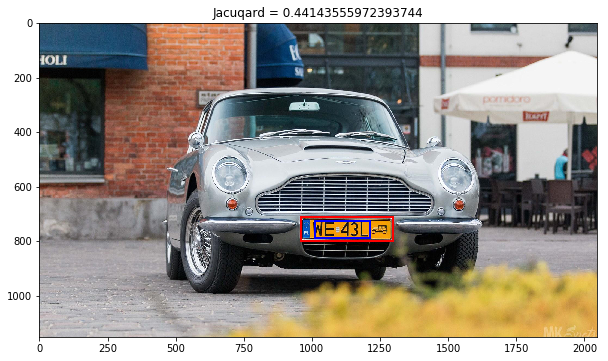

In [36]:
get_jacuqard_for_original_and_predicted_bbox(merged_df.loc[60], return_axes=True)


In [37]:
fp = sum(merged_df.iou < 0.5)
fp

10

In [38]:
merged_df[merged_df.iou < .5]

full_img_file     x_org     y_org  \
15  18353ae002808b62772c2d4ff245a13c594aea5b.jpg  0.525886  0.644306   
38  2c2f5fcbba2dfac3a35eae085c8c5e1ea39717d5.jpg  0.318750  0.586111   
39  2c2f5fcbba2dfac3a35eae085c8c5e1ea39717d5.jpg  0.318750  0.586111   
40  2c2f5fcbba2dfac3a35eae085c8c5e1ea39717d5.jpg  0.318750  0.586111   
44  34afacee7371c37c5508d15c5995a12b5d33d5c0.jpg  0.945833  0.399537   
60  237f57844ab25515a28db6f03499d788665fc0b5.jpg  0.551025  0.656386   
71  2636467c314655300c6e1b900156bd391a75272e.jpg  0.743750  0.768333   
83  01065ff856ce0e1e898876e4611a6d8985b0e8ba.jpg  0.417014  0.511574   
92  00b704b2edae78d2ed33813c74fa409971959527.jpg  0.654861  0.697222   
97  133fb009c06eace8c282799c3a63e9e1b69e05b8.jpg  0.675694  0.499074   

       w_org     h_org      text      x1     y1     w1     h1  x_pred  y_pred  \
15  0.151379  0.051482   ETMPW81   770.0  737.0  736.0  245.0   829.0   797.0   
38  0.198611  0.070370  ZSD29259   263.0   66.0  182.0   61.0   304.0    77.0   
39  0.198611  0.070370  ZSD29259   372.0   68.0  139.0   46.0   377.0    76.0   
40  0.198611  0.070370  ZSD29259   139.0   77.0  185.0   62.0   163.0    87.0   
44  0.076389  0.054630  WPI32932  1299.0  410.0  114.0   45.0  1352.0   407.0   
60  0.164551  0.075586     WE43L  1016.0  707.0  330.0  110.0  1011.0   724.0   
71  0.159167  0.110000   KR474LA   578.0  529.0  488.0  163.0   823.0   647.0   
83  0.217361  0.071296  GSL39405   484.0  487.0  328.0  109.0   540.0   520.0   
92  0.156944  0.062963   WI7907A   843.0  706.0  253.0   84.0   927.0   724.0   
97  0.168056  0.090741   HPUD152   556.0  428.0  657.0  263.0   888.0   472.0   

    w_pred  h_pred     pred_text  cas_idx       iou  
15   426.0    87.0  E?T?MPW81??E      0.0  0.375048  
38   146.0    40.0    TAAG?0URWA      0.0  0.000000  
39    82.0    35.0        OURWAU      0.0  0.000000  
40   118.0    42.0      BO0T?0?F      0.0  0.000000  
44    66.0    45.0         32932      1.0  0.452721  
60   201.0    64.0         WE43L      0.0  0.441436  
71   226.0    50.0         74LAW      0.0  0.379454  
83   208.0    56.0        L39405      0.0  0.486406  
92   125.0    54.0         7907A      0.0  0.442445  
97   334.0   190.0       HPUD152      1.0  0.303380

### Counts of good predictions per cascade

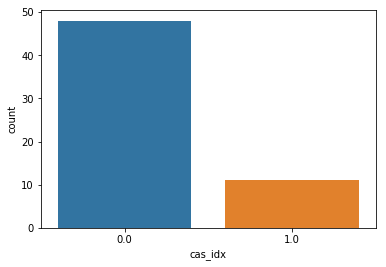

In [39]:
sns.countplot(x="cas_idx", data=merged_df[positives])

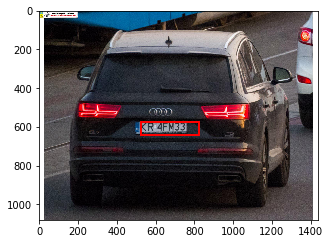

In [40]:
record = merged_df.loc[16]

bbox_pred = record[['x_pred', 'y_pred', 'w_pred', 'h_pred']].values

tmp_im = plt.imread(IMAGES_DIR / record.full_img_file)

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.imshow(tmp_im)
add_bbox_to_ax(bbox_pred, ax)

### experiments_results_normal_x.csv: 
- IoU bez znaków (tablica): 0.5442 ~ 0.54; TP=80, FP=27
- IoU ze znakami (tablica): 0.6213 ~ 0.62; TP=97, FP=10

Przyrost:

In [43]:
(0.62 - 0.54) / 0.54 * 100

14.814814814814806

### Plates that cascade failed on

In [42]:
merged_df[merged_df.pred_text == 'no_plate'].full_img_file

51    3f1e7d6a557803a4f4de8c06582521d6da88bb7e.jpg
55    03c182293e4101af6cf7c9f4427b3265fbeb4024.jpg
88    1becce6ee210a3dbad7831724a366a45bd9394df.jpg
90    3b280afcb75c5e056abd30bee84e0882bbd8e84c.jpg
93    20f11bece3be4167dc28d9446e68372aa2cf5d1d.jpg
Name: full_img_file, dtype: object